# 0. Importing libraries and initial setups

In [1]:
from plotly.offline import init_notebook_mode
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings

# Ignore warnings (from sklearn and seaborn)
def ignore_warnings(*args, **kwargs):
    pass
warnings.warn = ignore_warnings

# Limiting floats outputs to 3 decimal points
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# Doing this to make sure the graphs are visible in the kaggle kernels and not just a blank white screen
init_notebook_mode()

# 1. Reading data from files

In [2]:
import os
for dirname, _, filenames in os.walk('./data/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if 'train' in path:
            train_path = path
        elif 'test' in path:
            test_path = path

In [3]:
train = pd.read_csv(train_path)
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
test = pd.read_csv(test_path)
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH       80.000    11622   Pave   NaN      Reg   
1  1462          20       RL       81.000    14267   Pave   NaN      IR1   
2  1463          60       RL       74.000    13830   Pave   NaN      IR1   
3  1464          60       RL       78.000     9978   Pave   NaN      IR1   
4  1465         120       RL       43.000     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

The 'Id' column is not needed until submission time and can safely be dropped from both the training and testing dataset

In [5]:
print(f'Train data shape before dropped Id column: {train.shape}')
print(f'Test data shape before dropped Id column: {test.shape}')

submission_id = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

print(f'Train data shape after dropped Id column: {train.shape}')
print(f'Test data shape after dropped Id column: {test.shape}')

Train data shape before dropped Id column: (1460, 81)
Test data shape before dropped Id column: (1459, 80)
Train data shape after dropped Id column: (1460, 80)
Test data shape after dropped Id column: (1459, 79)


# 2. Analyzing Data

### 2.1 Correlation HeatMap

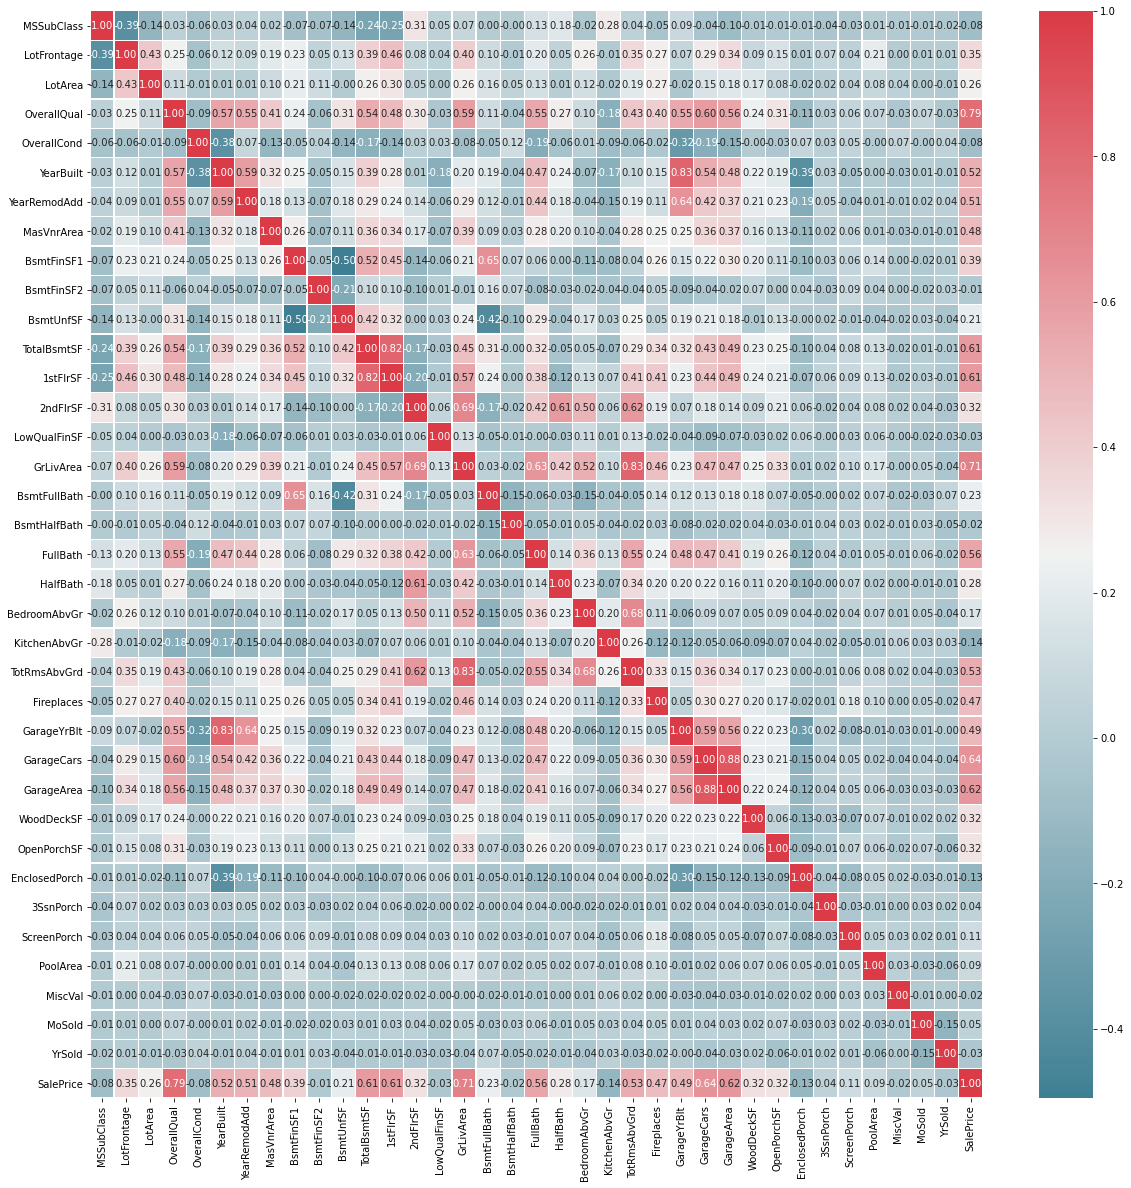

In [6]:
corrmat = train.corr()
fig, ax = plt.subplots(figsize=(20,20))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corrmat, 
            xticklabels=corrmat.columns.values, yticklabels=corrmat.columns.values,
            annot=True, fmt='.2f', linewidths=0.30,
            cmap=colormap, linecolor='white', ax=ax)
plt.show()

SalePrice is strongly correlated (0.6 or higher) with:
1. OverallQual and GrLivArea
2. TotalBsmtSF/1stFlrSF and GarageCars/GarageArea (both of which have already been established to be related)
3. Some "weaker" but worth considering features are: YearBuilt, YearRemodAdd, MassVnrArea, FullBath, TotRmsAbvGrd

There are also some few key things to note here:
1. YearBuilt is related to GarageYrBlt, which makes sense as a garage is usually built at the same time as the house
2. TotalBsmtSF and 1stFlrSF are related. This is probably because the basement probably equals in size to the house's foundation, which more than is covered by the 1st floor of the house.
3. GrLivArea is more related to 2ndFlrSF than 1stFlrSF, which is definitely interesting as one would imagine the 1st floor area will make up a larger portion of the house.
4. GrLivArea is also strongly related to TotRmsAbvGrd. More space means more room.

## 2.2 Relationship between SalePrice and some numerical features

### 2.2.1 GrLivArea

GrLivArea is the strongest indication of SalePrice among the numerical features

In [7]:
fig = px.scatter(train, x='GrLivArea', y='SalePrice', 
                 title='Relationship between Ground Living Area and Sale Price',
                 template='ggplot2')
fig.show()

**SHOCKING NEWS:** A house with bigger ground living area has a higer sale price

However, there are 2 houses that don't follow the trend (sold at really low price for such a big house). But before they can be dropped for being outliers, let's see if other features have anything to say

### 2.2.2 1stFlrSF

As mentioned above, this feature is interesting as one would think it is more related to GrLivArea than 2ndFlrSF. Also, while GrLivArea and 1stFlrSF have a fairly high correlation with SalePrice, 2ndFlrSF does not, which makes it even more interesting

In [8]:
fig = px.scatter(train, x='1stFlrSF', y='SalePrice', 
                 title='Relationship between 1st Floor Area and Sale Price',
                 template='ggplot2')
fig.show()

Once again, there is nothing out of ordinary except the data definitely more spread-out

And once again, this feature has outlier, but this time, there is only one of it. While it is more than likely than one of the GrLivArea's outliers will also be this outlier, where does the other one go?

In [9]:
train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 2e5)].loc[:, ['GrLivArea', '1stFlrSF']]

GrLivArea  1stFlrSF
523        4676      3138
1298       5642      4692

While House #1298 is definitely an outlier, House #523 definitely stays more inline this time around.

### 2.2.3 TotalBsmtSF

Considering TotalBsmtSF and 1stFlrSF have such a high correlation, no wonder they also have a similar effect on SalePrice

In [10]:
fig = px.scatter(train, x='TotalBsmtSF', y='SalePrice', 
                 title='Relationship between Total Basement Area and Sale Price',
                 template='ggplot2')
fig.show()

To no one's surprise, the TotalBsmtSF's graph looks fairly similar to the 1stFlrSF's one, bar the datapoints with 0 basement.

And once again, there is one big outlier in the train data.

In [11]:
train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 2e5)].loc[:, ['GrLivArea', 'TotalBsmtSF']]

GrLivArea  TotalBsmtSF
523        4676         3138
1298       5642         6110

House #1298 becomes more and more of a pain in the butt. It is definite time to get rid of it

In [12]:
train.drop(1298, inplace=True)

fig = px.scatter(train, x='GrLivArea', y='SalePrice', 
                 title='Relationship between Ground Living Area and Sale Price',
                 template='ggplot2')
fig.show()

fig = px.scatter(train, x='1stFlrSF', y='SalePrice', 
                 title='Relationship between 1st Floor Area and Sale Price',
                 template='ggplot2')
fig.show()

fig = px.scatter(train, x='TotalBsmtSF', y='SalePrice', 
                 title='Relationship between Total Basement Area and Sale Price',
                 template='ggplot2')
fig.show()

That looks a lot better.

### 2.2.4 GarageArea

In [13]:
fig = px.scatter(train, x='GarageArea', y='SalePrice', 
                 title='Relationship between Open Porch Area and Sale Price',
                 template='ggplot2')
fig.show()

A more luxury house tends to have a bigger garage. 

However, even though GarageArea seems to have a more linear relationship with SalePrice comparing to TotalBsmtSF based on the graph (the datapoints spread out far less in this graph comparing to the one of TotalBsmtSF or 1stFlrSF), it only has a slightly stronger correlation (.62 versus .61).

This can be explained with:
1. While the data points follow the same trend, GarageArea seems to be more spread out than TotalBsmtSF.
2. Fewer houses have no basement comparing to no garage (GarageArea = 0). This one is even more perplexing but anyway

In [14]:
no_basement = train[train['TotalBsmtSF'] == 0].shape[0]
no_garage = train[train['GarageArea'] == 0].shape[0]
print(f'Houses with no basement = {no_basement} - Houses with no garage = {no_garage}')

Houses with no basement = 37 - Houses with no garage = 81


### 2.2.4 OpenPorchSF

OpenPorchSF is a feature with a mediocre correlation with SalePrice

In [15]:
fig = px.scatter(train, x='OpenPorchSF', y='SalePrice', 
                 title='Relationship between Open Porch Area and Sale Price',
                 template='ggplot2')
fig.show()

And as expected, there doesn't seem to be any kind of relationship between SalePrice and OpenPorchSF, not even polynomial or logarithmic one.

**In summary:**
1. Numerical features that have strong linear relationship with SalePrice are: GrLivArea, TotalBsmtSF, 1stFlrSF, GarageArea 
2. Outliers appear in some features in the training set, and has been dealt with accordingly. 

## 2.3 Relationship between SalePrice and numerically categorical feature

These are the features that are technically numerical (appear in the correlation heatmap above because their values are numbers) but act more like a categorical features as the values iteself are not continuous.

Features that fall into this category: GarageCars, YearBuilt, FullBath, etc.

For example: a house's garage can either hold 2 or 3 cars, not 2.5 cars.

### 2.3.1 OverallQual
OverallQual is not only the best indicator of SalePrice among the numerically categorical features, but also across all numerical features in general

In [16]:
fig = px.box(train, x='OverallQual', y='SalePrice', template='ggplot2')
fig.show()

And as expected, a house with higher overall quality tends to have higher SalePrice. However, the relationship looks more to be exponential rather than linear.

The only exception is a house at seemingly sub-par condition (4) with a relatively high price (256k).

One more thing is that as the overall quality increases, the house's price varies a lot more. 

### 2.3.2 GarageCars
GarageCars is also a strong indicator of SalePrice, even stronger than its brother GarageArea.

In [17]:
fig = px.box(train, x='GarageCars', y='SalePrice', template='ggplot2')
fig.show()

Based on the graph, if anyone want to sale their house at a higher price, having a 3-car garage will help a lot with the price tag. But don't be to greedy and expand it further since it will make the house less valuable.

### 2.3.3 TotRmsAbvGrd
Now this is the territory of average indicator. TotRmsAbvGrd is a feature that directly correlated with GrLivArea. So we can expect similar effect on SalePrice as GrLivArea as well.

In [18]:
fig = px.box(train, x='TotRmsAbvGrd', y='SalePrice', template='ggplot2')
fig.show()

As expected, a larger house with more rooms will sell at a higher price. However, the SalePrice seems to peek at around 10-11 rooms, anything more than that will have a negative impact on the price.

One thing also to note is the fact there is no house with 13 rooms and only one 14 with 14 rooms in the training dataset, makes it an outlier. However, since the testing has 2 houses have 13 or more rooms in the dataset, it is better to just keep this seemingly outlier.

In [19]:
train[train['TotRmsAbvGrd'] >= 13].loc[:, 'TotRmsAbvGrd']

635    14
Name: TotRmsAbvGrd, dtype: int64

In [20]:
test[test['TotRmsAbvGrd'] >= 13].loc[:, 'TotRmsAbvGrd']

442     13
1089    15
Name: TotRmsAbvGrd, dtype: int64

### 2.3.4 FullBath

In [21]:
fig = px.box(train, x='FullBath', y='SalePrice', template='ggplot2')
fig.show()

A more luxurious house with more full bathroom will be sold at a higer price. However, there are 2 things that are concerning:
1. Who wants to buy a house with 0 full bathrooms?
2. Why is the range of the price of the 0-fullbath house so wide?

### 2.3.5 YearBuilt and GarageYrBlt

Considering these two features have a very strong correlation to each other and rought the same correlation with SalePrice, let's visualize both of them together

In [22]:
fig = px.box(train, x='YearBuilt', y='SalePrice', template='ggplot2')
fig.show()
fig = px.box(train, x='GarageYrBlt', y='SalePrice', template='ggplot2')
fig.show()

There seems to be some sort of exponential relationship between these two features with SalePrice, but that is a little bit of a stretch.

### 2.3.6 YearRemodAdd
And last, but not least, is the YearRemodAdd

In [23]:
fig = px.box(train, x='YearRemodAdd', y='SalePrice', template='ggplot2')
fig.show()

The relationship between YearRemodAdd and SalePrice is more or less the same as YearBuilt, which is not that surprising since:
1. Less than half of the houses went through a remodeling, which means more than half of the data points have the same vaue for YearBuilt and YearRemodAdd
2. A more recent remodeled house is not guaranteed to be in a better condition than a original house, and we know OverallQual is a strong indicator.

# 3. Missing Data

In [24]:
# Calculate the missing ratio of each feature in both the training and testing dataset
train_missing = train.isnull().sum() / len(train) * 100
test_missing = test.isnull().sum() / len(test) * 100

# Combine the two calculated Series together
missing_data = pd.DataFrame({'Missing Ratio in Train': train_missing, 'Missing Ratio in Test': test_missing})

# Drop the features that have 0% missing ratio in both training and testing dataset
missing_data.drop(
    missing_data[(missing_data['Missing Ratio in Train'] == 0) & (missing_data['Missing Ratio in Test'] == 0)].index,
    inplace=True)
# Drop the SalePrice feature since it is available for testing dataset
missing_data.drop(missing_data[missing_data['Missing Ratio in Test'].isna()].index, inplace=True)
missing_data = missing_data.sort_values(by='Missing Ratio in Train', ascending=False)
missing_data

Missing Ratio in Train  Missing Ratio in Test
PoolQC                        99.589                 99.794
MiscFeature                   96.299                 96.504
Alley                         93.763                 92.666
Fence                         80.740                 80.123
FireplaceQu                   47.293                 50.034
LotFrontage                   17.752                 15.559
GarageYrBlt                    5.552                  5.346
GarageQual                     5.552                  5.346
GarageFinish                   5.552                  5.346
GarageCond                     5.552                  5.346
GarageType                     5.552                  5.209
BsmtFinType2                   2.605                  2.879
BsmtExposure                   2.605                  3.016
BsmtQual                       2.536                  3.016
BsmtFinType1                   2.536                  2.879
BsmtCond                       2.536                  3.084
MasVnrType                     0.548                  1.097
MasVnrArea                     0.548                  1.028
Electrical                     0.069                  0.000
MSZoning                       0.000                  0.274
KitchenQual                    0.000                  0.069
SaleType                       0.000                  0.069
TotalBsmtSF                    0.000                  0.069
GarageArea                     0.000                  0.069
GarageCars                     0.000                  0.069
Functional                     0.000                  0.137
Exterior2nd                    0.000                  0.069
Exterior1st                    0.000                  0.069
BsmtUnfSF                      0.000                  0.069
BsmtHalfBath                   0.000                  0.137
BsmtFullBath                   0.000                  0.137
BsmtFinSF2                     0.000                  0.069
BsmtFinSF1                     0.000                  0.069
Utilities                      0.000                  0.137

Quite a few features are missing data in both training and testing dataset, some of them by a large margin.

At the same time, missing data seems to a bigger issue for the testing dataset as there are only 19 features have missing data in the training set, comparing to 33 from the testing set.

**PoolQC:** data description says NA means No Pool. This makes sense most houses don't have a pool and the dataset reflects that

In [25]:
train['PoolQC'].fillna(value='None', inplace=True)
test['PoolQC'].fillna(value='None', inplace=True)

**MiscFeature:** data description says NA means No Misc Features

In [26]:
train['MiscFeature'].fillna(value='None', inplace=True)
test['MiscFeature'].fillna(value='None', inplace=True)

**Alley:** data description says NA means the house has no alley access

In [27]:
train['Alley'].fillna(value='None', inplace=True)
test['Alley'].fillna(value='None', inplace=True)

**Fence:** data description says NA means the house has no fence

In [28]:
train['Fence'].fillna(value='None', inplace=True)
test['Fence'].fillna(value='None', inplace=True)

**FireplaceQu:** data description says NA means the house has no fireplace

In [29]:
train['FireplaceQu'].fillna(value='None', inplace=True)
test['FireplaceQu'].fillna(value='None', inplace=True)

**LotFrontage:** Since houses within a neighborhood most likely to have a similar lot frontage area, the missing value can be filled with the median LotFrontage of the neighborhood

In [30]:
# Lookup the most median Lot Frontage of each neighborhood in the training dataset
lookup = train.groupby('Neighborhood')['LotFrontage'].agg(pd.Series.median)

train['LotFrontage'].fillna(train['Neighborhood'].map(lookup), inplace=True)
test['LotFrontage'].fillna(test['Neighborhood'].map(lookup), inplace=True)

**MSZoning**: Since house within a neighborhood most likely to be assigned the same zone, the missing value can be replaced with the most common zoning of the neighborhood

In [31]:
# Lookup the most common Zoning of each neighborhood in the training dataset
lookup = train.groupby('Neighborhood')['MSZoning'].agg(pd.Series.mode)

train['MSZoning'].fillna(train['Neighborhood'].map(lookup), inplace=True)
test['MSZoning'].fillna(test['Neighborhood'].map(lookup), inplace=True)

**GarageType, GarageFinish, GarageQual, GarageCond:** data description indicates NA means no garage

In [32]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[col].fillna(value='None', inplace=True)
    test[col].fillna(value='None', inplace=True)

**GarageArea, GarageCars**: replacing NA with 0, since no garage means no cars in the garage

In [33]:
for col in ['GarageArea', 'GarageCars']:
    train[col].fillna(value=0, inplace=True)
    test[col].fillna(value=0, inplace=True)

**GarageYrBlt:** replacing NA with 0 doesn't make a lot of sense because it creates the impression that the garage is built in the begining of the Roman Empire. Instead, if the garage info is missing, let's just assume the Garage is built at the same year as the house, it just happens to not have any space for cars.

In [34]:
train['GarageYrBlt'].fillna(train['YearBuilt'], inplace=True)
test['GarageYrBlt'].fillna(test['YearBuilt'], inplace=True)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2:** missing value likely means that the house has no basement

In [35]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[col].fillna(value='None', inplace=True)
    test[col].fillna(value='None', inplace=True)
    
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    train[col].fillna(value=0, inplace=True)
    test[col].fillna(value=0, inplace=True)

**MasVnrArea and MasVnrType:** NA most likely means no masonry veneer for these houses. That means missing area can be replaced with 0 and missing type can be replaced with None

In [36]:
train['MasVnrArea'].fillna(value=0, inplace=True)
train['MasVnrType'].fillna(value='None', inplace=True)

test['MasVnrArea'].fillna(value=0, inplace=True)
test['MasVnrType'].fillna(value='None', inplace=True)

**Electrical, Exterior1st, Exterior2nd, and SaleType:** missing value can be replaced by the most common value of the training data

In [37]:
for col in ['Electrical', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    mode = train[col].mode()[0]
    train[col].fillna(value=mode, inplace=True)
    test[col].fillna(value=mode, inplace=True)

**Kitchen Quality**:

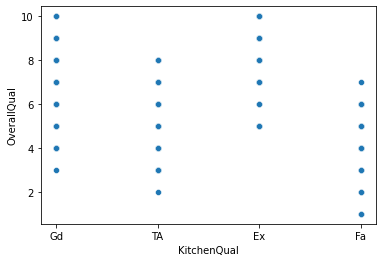

In [38]:
fit, ax = plt.subplots()
sns.scatterplot(data=train, x='KitchenQual', y='OverallQual')
plt.show()

As expected, the better the condition the house is in, the better of its kitchen's condition. Hence, missing values of KitchenQual can be replaced with the mode in each OverallQual group

In [39]:
# Lookup the most common Kitchen Quality for each Overall Quality category in the training dataset
lookup = train.groupby('OverallQual')['KitchenQual'].agg(pd.Series.mode)

train['KitchenQual'].fillna(train['OverallQual'].map(lookup), inplace=True)
test['KitchenQual'].fillna(test['OverallQual'].map(lookup), inplace=True)

**Utilities:** In the training set, every house except for 1 has the AllPub value for Utilities. And in the testing set, besides 2 NA values, the rest has exclusively AllPub. Which means this feature won't help much in training the model and can be safely removed

In [40]:
train.drop(['Utilities'], axis=1, inplace=True)
test.drop(['Utilities'], axis=1, inplace=True)

**Functional:** data description says to assume Typical unless specified

In [41]:
train['Functional'].fillna(value='Typ', inplace=True)
test['Functional'].fillna(value='Typ', inplace=True)

**MSSubClass:** NA most likely means No building sub-class, which means missing value can be replaced with None

In [42]:
train['MSSubClass'].fillna(value='None', inplace=True)
test['MSSubClass'].fillna(value='None', inplace=True)

Double-check to see if there is any more missing value

In [43]:
# Calculate the missing ratio of each feature in both the training and testing dataset
train_missing = train.isnull().sum() / len(train) * 100
test_missing = test.isnull().sum() / len(test) * 100

# Combine the two calculated Series together
missing_data = pd.DataFrame({'Missing Ratio in Train': train_missing, 'Missing Ratio in Test': test_missing})

# Drop the features that have 0% missing ratio in both training and testing dataset
missing_data.drop(
    missing_data[(missing_data['Missing Ratio in Train'] == 0) & (missing_data['Missing Ratio in Test'] == 0)].index,
    inplace=True)
# Drop the SalePrice feature since it is available for testing dataset
missing_data.drop(missing_data[missing_data['Missing Ratio in Test'].isna()].index, inplace=True)
missing_data = missing_data.sort_values(by='Missing Ratio in Train', ascending=False)
missing_data

Empty DataFrame
Columns: [Missing Ratio in Train, Missing Ratio in Test]
Index: []

# 4. Features Engineering

## 4.1 Feature skewness

In [44]:
def show_hist_plot(dataset, col):
    (mu, sigma) = norm.fit(dataset[col]);
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10));
    sns.histplot(data=dataset, x=col, kde=True, ax=ax[0]);
    ax[0].legend(
        [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
        loc='best');
    
    fig = plt.figure();
    res = stats.probplot(dataset[col], plot=ax[1]);
    
    plt.show();

### 4.1.1 SalePrice

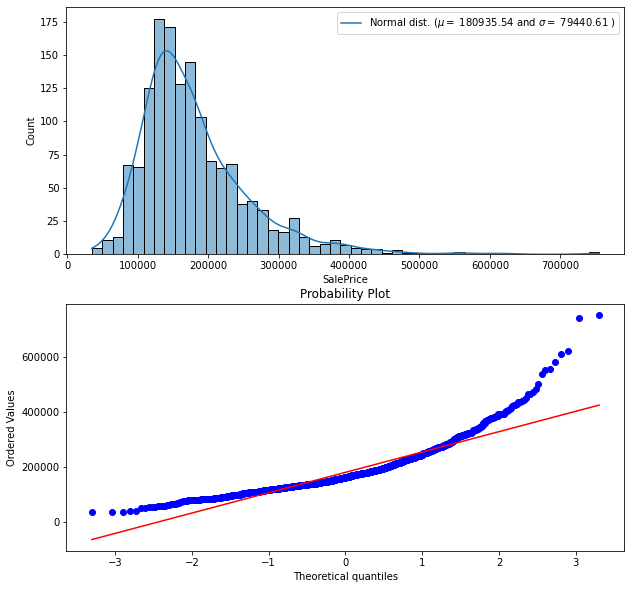

<Figure size 432x288 with 0 Axes>

In [45]:
show_hist_plot(train, 'SalePrice');

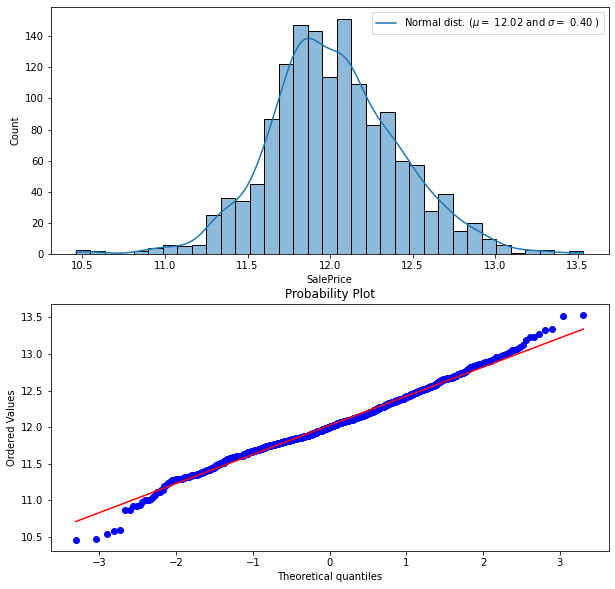

<Figure size 432x288 with 0 Axes>

In [46]:
train['SalePrice'] = np.log1p(train['SalePrice'])
show_hist_plot(train, 'SalePrice')

## 4.2 Label Encoding categorical features

In [47]:
columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 
           'LotShape', 'LotConfig', 'LandContour', 'LandSlope',
           'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
           'HouseStyle', 'OverallQual', 'OverallCond', 
           'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
           'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath',
           'BsmtHalfBath', 'Electrical' , 'FullBath', 'HalfBath',
           'Heating', 'HeatingQC', 'CentralAir', 'BedroomAbvGr',
           'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
           'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
           'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
           'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
for c in columns:
    le = LabelEncoder()
    values = set(train[c].values) | set(test[c].values)
    le.fit(list(values))
    train[c] = le.transform(list(train[c].values))
    test[c] = le.transform(list(test[c].values))

# 5. Modeling

In [48]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [51]:
x, y = train.drop('SalePrice', axis=1), train['SalePrice']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state=42)
x_test = test

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape)

(1167, 78) (292, 78)
(1167,) (292,)
(1459, 78)


In [50]:
# lasso = Lasso(alpha=.1, max_iter=500)
# lasso.fit(x_train, y_train)
# y_pred = lasso.predict(x_val)
# score = accuracy_score(y_val, y_pred)
# print(f'Lasso Score: {score}')

ValueError: Found input variables with inconsistent numbers of samples: [1167, 292]